In [1]:
# Config
import os
import json
import geojson
import leafmap.leafmap as leafmap
import requests
from PIL import Image

# Basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Monitoring
from tqdm.notebook import tqdm

# IO
from os.path import join, exists, basename, dirname, splitext, expanduser
from glob import glob
from shapely.geometry import Point
from shapely import vectorized

import geopandas as gpd

# Parallel processing
from joblib import Parallel, delayed
import concurrent.futures as cf

import rioxarray as rxr

# Load environment variables
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import os
# for key in os.environ:
#     # print(key)

In [3]:
region = "chittagong" # "uttar_pradesh", "delhi_airshed", "wb_small_airshed", "lucknow_airshed", "ahmedabad_10km_buffer", "bihar"
download_dir = "../raw_data"
quarter = "2024q1"
PLANET_API_KEY="PLAKea85382c048b4ba086c40e3823d83d11"
# PLANET_API_KEY = os.getenv("PLANET_API_KEY")
print(PLANET_API_KEY)
assert PLANET_API_KEY is not None
shape_path = f"../regions/shapes/{region}.geojson"
print(shape_path)

shape_gdf = gpd.read_file(shape_path)
shape_gdf = shape_gdf.to_crs("EPSG:4326")

print(shape_gdf.crs)
print(shape_gdf.tail()) 

PLAKea85382c048b4ba086c40e3823d83d11
../regions/shapes/chittagong.geojson
EPSG:4326
      ADM1_EN                                           geometry
0  chittagong  MULTIPOLYGON (((92.32719 20.63543, 92.32749 20...


<Axes: >

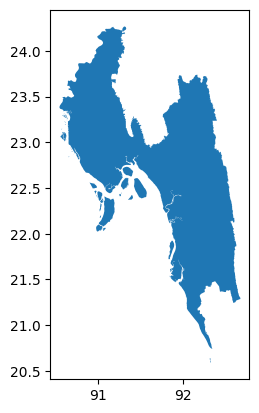

In [4]:
##aceess the Rajshahi division

shape_gdf = shape_gdf[shape_gdf["ADM1_EN"] == f"{region}"]
shape_gdf.plot()

In [5]:


m = leafmap.Map()
m.add_basemap("HYBRID")
m.add_gdf(shape_gdf, zoom_to_layer=True)
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [6]:
headers = {"Authorization": f"api-key {PLANET_API_KEY}"}
params = {
    "name__contains": quarter,
}

response = requests.get(f"https://api.planet.com/basemaps/v1/mosaics", headers=headers, params=params)
response.json()

{'_links': {'_self': 'https://api.planet.com/basemaps/v1/mosaics?api_key=PLAKea85382c048b4ba086c40e3823d83d11'},
 'mosaics': [{'_links': {'_self': 'https://api.planet.com/basemaps/v1/mosaics/a378ff71-e48b-4602-9993-bb2896a68ab3?api_key=PLAKea85382c048b4ba086c40e3823d83d11',
    'quads': 'https://api.planet.com/basemaps/v1/mosaics/a378ff71-e48b-4602-9993-bb2896a68ab3/quads?api_key=PLAKea85382c048b4ba086c40e3823d83d11&bbox={lx},{ly},{ux},{uy}',
    'tiles': 'https://tiles.planet.com/basemaps/v1/planet-tiles/global_quarterly_2024q1_mosaic/gmap/{z}/{x}/{y}.png?api_key=PLAKea85382c048b4ba086c40e3823d83d11'},
   'bbox': [-179.999999974944,
    -59.623325217855,
    179.999999975056,
    76.016093660188],
   'coordinate_system': 'EPSG:3857',
   'datatype': 'byte',
   'first_acquired': '2024-01-01T00:00:00.000Z',
   'grid': {'quad_size': 4096, 'resolution': 4.777314267823516},
   'id': 'a378ff71-e48b-4602-9993-bb2896a68ab3',
   'interval': '3 mons',
   'item_types': ['PSScene'],
   'last_acqui

In [7]:
assert len(response.json()["mosaics"]) == 1
mosaic = response.json()["mosaics"][0]
print(mosaic['name'])
print(mosaic['id'])

global_quarterly_2024q1_mosaic
a378ff71-e48b-4602-9993-bb2896a68ab3


In [8]:
print(download_dir)
# region='rajshahi'
metadata_save_dir = join(download_dir, "metadata", region, mosaic['name'])
print(metadata_save_dir)

../raw_data
../raw_data/metadata/chittagong/global_quarterly_2024q1_mosaic


In [9]:
min_lon, min_lat, max_lon, max_lat = shape_gdf.bounds.values[0]
print(min_lon, min_lat, max_lon, max_lat)

90.53868604700006 20.590609348000044 92.68030687500004 24.267971368000076


In [10]:
params = {
    "bbox": f"{min_lon},{min_lat},{max_lon},{max_lat}",
    "_page_size": 10000,
}

response = requests.get(f"https://api.planet.com/basemaps/v1/mosaics/{mosaic['id']}/quads", headers=headers, params=params)
quads = response.json()['items']
print("Number of quads:", len(quads))

Number of quads: 247


  0%|          | 0/247 [00:00<?, ?it/s]

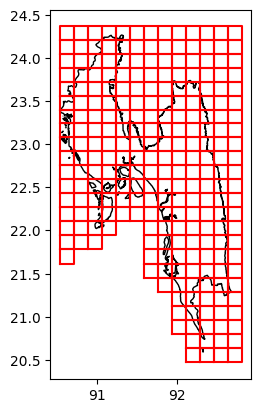

In [11]:
shape_gdf.plot(color="none", edgecolor="black")
for quad in tqdm(quads):
    bounds = quad['bbox']
    plt.plot([bounds[0], bounds[2], bounds[2], bounds[0], bounds[0]], [bounds[1], bounds[1], bounds[3], bounds[3], bounds[1]], color="red")

In [12]:
bboxes = np.array([quad['bbox'] for quad in quads])
print(f"{bboxes.shape=}")

top_left_inside = vectorized.contains(shape_gdf.geometry.item(), bboxes[:, 0], bboxes[:, 3])
top_right_inside = vectorized.contains(shape_gdf.geometry.item(), bboxes[:, 2], bboxes[:, 3])
bottom_left_inside = vectorized.contains(shape_gdf.geometry.item(), bboxes[:, 0], bboxes[:, 1])
bottom_right_inside = vectorized.contains(shape_gdf.geometry.item(), bboxes[:, 2], bboxes[:, 1])
one_of_the_corners_inside = np.logical_or(np.logical_or(top_left_inside, top_right_inside), np.logical_or(bottom_left_inside, bottom_right_inside))
print(f"{one_of_the_corners_inside.sum()=}")

bboxes.shape=(247, 4)
one_of_the_corners_inside.sum()=137


In [13]:
quads_within_roi = np.array(quads)[one_of_the_corners_inside]
quads_within_roi.shape

(137,)

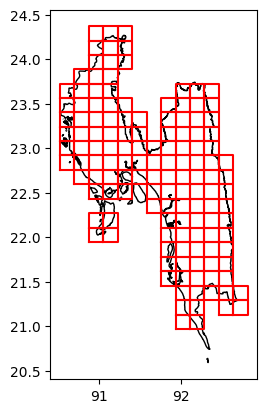

In [14]:
shape_gdf.plot(color="none", edgecolor="black")
for quad in quads_within_roi:
    bounds = quad['bbox']
    plt.plot([bounds[0], bounds[2], bounds[2], bounds[0], bounds[0]], [bounds[1], bounds[1], bounds[3], bounds[3], bounds[1]], color="red")

In [15]:
# each item in quads_within_roi is a dict. Combine into a geojson feature collection
features = []
for quad in tqdm(quads_within_roi):
    feature = {
        "type": "Feature",
        "geometry": {
            "type": "Polygon",
            "coordinates": [[
                [quad['bbox'][0], quad['bbox'][1]],
                [quad['bbox'][2], quad['bbox'][1]],
                [quad['bbox'][2], quad['bbox'][3]],
                [quad['bbox'][0], quad['bbox'][3]],
                [quad['bbox'][0], quad['bbox'][1]],
            ]],
        },
        "properties": {
            "_self": quad['_links']['_self'],
            "download": quad['_links']['download'],
            "items": quad['_links']['items'],
            "thumbnail": quad['_links']['thumbnail'],
            "id": quad['id'],
            "percent_covered": quad['percent_covered'],
        }
    }
    features.append(feature)
    
collection = geojson.FeatureCollection(features)

  0%|          | 0/137 [00:00<?, ?it/s]

In [16]:
os.makedirs(metadata_save_dir, exist_ok=True)
with open(join(metadata_save_dir, "metadata.geojson"), "w") as f:
    geojson.dump(collection, f)

In [17]:
with open(join(metadata_save_dir, "metadata.geojson"), "r") as f:
    collection = geojson.load(f)

In [18]:
features = collection['features']
print(f"{len(features) = }")
set([feature['properties']['percent_covered'] for feature in features])

len(features) = 137


{100}

In [19]:
print(features[0])

{"geometry": {"coordinates": [[[90.878906, 24.20689], [91.054687, 24.20689], [91.054687, 24.367114], [90.878906, 24.367114], [90.878906, 24.20689]]], "type": "Polygon"}, "properties": {"_self": "https://api.planet.com/basemaps/v1/mosaics/a378ff71-e48b-4602-9993-bb2896a68ab3/quads/1541-1166?api_key=PLAKea85382c048b4ba086c40e3823d83d11", "download": "https://link.planet.com/basemaps/v1/mosaics/a378ff71-e48b-4602-9993-bb2896a68ab3/quads/1541-1166/full?api_key=PLAKea85382c048b4ba086c40e3823d83d11", "id": "1541-1166", "items": "https://api.planet.com/basemaps/v1/mosaics/a378ff71-e48b-4602-9993-bb2896a68ab3/quads/1541-1166/items?api_key=PLAKea85382c048b4ba086c40e3823d83d11", "percent_covered": 100, "thumbnail": "https://tiles.planet.com/basemaps/v1/planet-tiles/global_quarterly_2024q1_mosaic/gmap/11/1541/881.png?api_key=PLAKea85382c048b4ba086c40e3823d83d11"}, "type": "Feature"}


In [20]:
download_imagery_dir = join(download_dir, "imagery", mosaic['name'])
print(download_imagery_dir)
os.makedirs(download_imagery_dir, exist_ok=True)

../raw_data/imagery/global_quarterly_2024q1_mosaic


In [22]:


def download_feature(feature):
    file_id = feature['properties']['id']
    file_path = join(download_imagery_dir, f"{file_id}.tif")
    
    download_url = feature['properties']['download']
    if exists(file_path):
        try:
            image = Image.open(file_path)
            assert image.size == (4096, 4096)
            # print(f"File already exists: {file_path}.")
            return  # Skip if the file is already downloaded and is not corrupted
        except:
            print(f"Corrupted file: {file_path}.")

    response = requests.get(download_url, headers=headers)

    # print(f"{response.status_code=}")
    with open(file_path, "wb") as f:
        f.write(response.content)
        
    da = rxr.open_rasterio(file_path)
    # round x, y to 6 decimal places
    da = da.assign_coords(x=np.round(da.x, 6))
    da = da.assign_coords(y=np.round(da.y, 6))
    kwargs = {'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}
    da.rio.to_raster(file_path, **kwargs)
    
    # reload for testing
    # reload_da = rxr.open_rasterio(file_path)
    # return reload_da

# test
# da = download_feature(features[0])
# da.x.values[0:5]
# _ = Parallel(n_jobs=48)(delayed(download_feature)(feature) for feature in tqdm(features))
with cf.ThreadPoolExecutor(max_workers=48) as executor:
    list(tqdm(executor.map(download_feature, features), total=len(features)))

  0%|          | 0/137 [00:00<?, ?it/s]

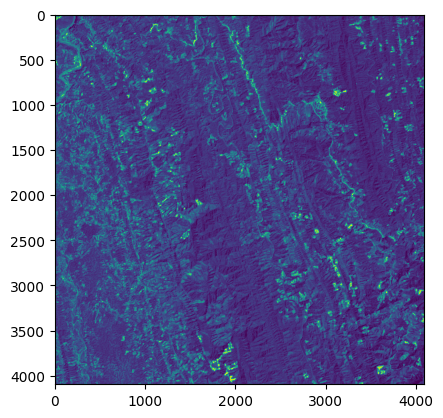

In [23]:
#visualize the downloaded images
import rasterio
import matplotlib.pyplot as plt
data=rasterio.open('../raw_data/imagery/global_quarterly_2024q1_mosaic/1550-1157.tif')
plt.imshow(data.read(1))

In [27]:
corruptepetd_files = "../raw_data/imagery/global_quarterly_2024q1_mosaic/1531-1164.tif"
os.remove(corruptepetd_files)
print("Removed corrupted files")


Removed corrupted files
